# Mean vs genome
**in the protein coding gene length distributions for the different species**

## Import python modules

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from plotnine import *

import sys
sys.path.append('../../gene_length/gl_lib/')
import gl_constants as c
import gl_plot as gl_p

## The protein coding gene length distributions for the different species

### Retrieving the statistical descriptions of the gene length's distributions

#### Statistical description 

In [2]:
# statistics on length distributions 
stat_file = "/home/emuro/git/github/gene_length/main_tables/stat_protCodGenes.tsv"
print("The statistical descriptions of the protein coding gene distributions " + \
    "for the different species is in:\n", stat_file, "\n")

# retrieve data and diminish the number of columns
stat_df = pd.read_csv(stat_file, low_memory=False, sep="\t")
stat_df = stat_df[["division_both_dbs", "species", "taxonomy_id","count", "mean", "var", "log10_mean", "log10_var"]]

# visualize data
if 1:
    pd.set_option('display.max_columns', len(stat_df.columns))
    display(stat_df.sample(2))
    print(stat_df.shape)
    print(stat_df["division_both_dbs"].value_counts())

The statistical descriptions of the protein coding gene distributions for the different species is in:
 /home/emuro/git/github/gene_length/main_tables/stat_protCodGenes.tsv 



,division_both_dbs,species,taxonomy_id,count,mean,var,log10_mean,log10_var
13938,bacteria,longilinea_arvoryzae_gca_001050235,360412,3886,1023.310345,542039.241628,2.921155,0.079592
27391,bacteria,cellulomonas_sp_psbb021_gca_002240455,2003551,3252,999.426199,451214.684493,2.912411,0.078962


(33627, 8)
division_both_dbs
bacteria         30714
archaea           1229
fungi             1014
protists           237
vertebrates        222
invertebrates      115
plants              96
Name: count, dtype: int64


## Get the genome size  

In [3]:
# statistics on length distributions 
stat2_file = "/home/emuro/git/github/bioinf-genome_length/ensembl__taxid_species_goldenPath_division.tsv.bz2"
print("The genome sizes in bp, that I downloaded, " + \
    "for the different species is in:\n", stat2_file, "\n")

# retrieve data and diminish the number of columns
stat2_df = pd.read_csv(stat2_file, compression="bz2", low_memory=False, sep="\t")
#stat2_df = stat_df[["division_both_dbs", "species", "taxonomy_id","count", "mean", "var", "log10_mean", "log10_var"]]
stat2_df = stat2_df.rename(columns={"taxid": "taxonomy_id", "golden_path": "genome"})
# visualize data
if 1:
    pd.set_option('display.max_columns', len(stat2_df.columns))
    display(stat2_df.sample(2))
    print(stat2_df.shape)
    print(stat2_df["division"].value_counts())
print(stat_df["division_both_dbs"].value_counts())

The genome sizes in bp, that I downloaded, for the different species is in:
 /home/emuro/git/github/bioinf-genome_length/ensembl__taxid_species_goldenPath_division.tsv.bz2 



,taxonomy_id,species,genome,division
13933,469607,fusobacterium_nucleatum_subsp_animalis_4_8_gca...,2275461,EnsemblBacteria
23396,2305225,paraburkholderia_sp_dhoa04_gca_003837865,6096551,EnsemblBacteria


(33022, 4)
division
EnsemblBacteria       31332
EnsemblFungi           1014
EnsemblProtists         237
EnsemblVertebrates      227
EnsemblMetazoa          115
EnsemblPlants            96
EnsemblViruses            1
Name: count, dtype: int64
division_both_dbs
bacteria         30714
archaea           1229
fungi             1014
protists           237
vertebrates        222
invertebrates      115
plants              96
Name: count, dtype: int64


## Merge genome size column

In [4]:
# merge data frames
stat_df = (
    pd.merge(
        stat_df, stat2_df, 
        how='left', 
        left_on=['taxonomy_id', 'species'], right_on=['taxonomy_id', 'species']
        )
        .fillna({'genome':'NaN'})
)
# Counting NaN values in the 'golden_path' column
#print(stat2_df['genome'].isna().sum())


# visualize data
if 1:
    print("stat_df")
    pd.set_option('display.max_columns', len(stat_df.columns))
    display(stat_df.sample(2))
    print(stat_df.shape)

stat_df


,division_both_dbs,species,taxonomy_id,count,mean,var,log10_mean,log10_var,genome,division
1895,bacteria,pseudomonas_aeruginosa_gca_004795655,287,6951,928.701482,468421.819219,2.870864,0.087715,7205149,EnsemblBacteria
20001,bacteria,mycoplasma_cynos_c142_gca_000328725,1246955,883,1030.697622,837232.877851,2.863677,0.139467,998123,EnsemblBacteria


(33630, 10)


## mean vs. genome size (represented in $log_{10}$ scale)
### Protein coding gene's length

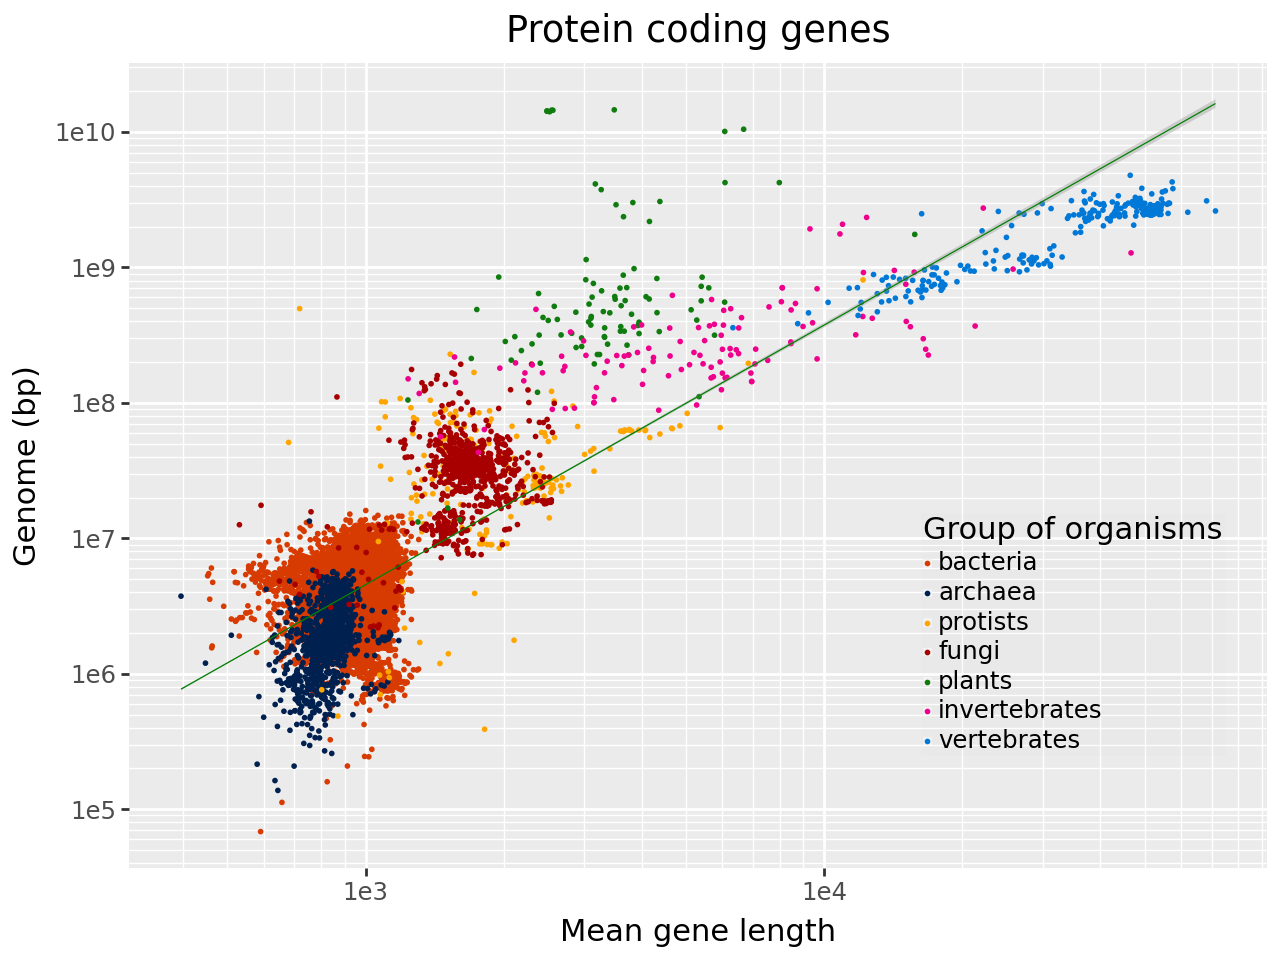

,division_both_dbs,species,taxonomy_id,count,mean,var,log10_mean,log10_var,genome,division
3658,bacteria,escherichia_coli_gca_005045595,562,4598,883.069378,402654.759380,2.839305,0.104141,4927569,EnsemblBacteria
28917,bacteria,psychromonas_sp_mb_3u_54_gca_002836415,2058319,3595,954.971627,833809.967475,2.876513,0.090028,4371403,EnsemblBacteria


(33630, 10)
division_both_dbs
bacteria         30714
archaea           1229
fungi             1015
protists           237
vertebrates        222
invertebrates      117
plants              96
Name: count, dtype: int64


In [5]:
col_x = "mean"  
col_y = "genome"  
legends_by = "division_both_dbs"

title = "Protein coding genes" # "Uniprot, reference Proteomes (protein length)"
x_lab = "Mean gene length"   
y_lab = "Genome (bp)"
#y_lab = "Number of prot. cod. genes"
bool_show_regression = True

df2plot = stat_df.copy()
#df2plot["genome"] = df2plot["genome"] - df2plot["count"] * df2plot["mean"]
if 0:
    print(df2plot.shape)

# Sort division_both_dbs in order to plot the color of the clades in order
if 0:
    print(df2plot.division_both_dbs.unique())
df2plot.division_both_dbs = pd.Categorical(df2plot.division_both_dbs, 
                                categories=c.ORG_GROUPS,           
                                ordered=True)
df2plot.sort_values('division_both_dbs', inplace=True)

p = (   
        ggplot(df2plot, aes(col_x, col_y, color=legends_by)) + 
        geom_point(size=0.15) + #, alpha=0.4 + # color, fill )
        geom_smooth(method="lm", color="green", size=0.25, span=.8) +
        labs(title=title, x=x_lab, y=y_lab) 
        + scale_color_manual(values=c.COLOR_ORG_GROUPS) 
        + labs(color='Group of organisms') # legend title
        + scale_x_log10(breaks=[10 ** power for power in range(6)])#,
        #  limits=[min(df2plot[col_x].to_list())/2, 2*max(df2plot[col_x].to_list())]) 
        + scale_y_log10(breaks = [10**power for power in range(11)])#, 
        #  limits = [min(df2plot[col_y].to_list())/2,2*max(df2plot[col_y].to_list())])#, labels=scientific_format(digits=2)
    ) + theme(legend_position=(0.95,0.2), legend_key_size=2, \
        legend_background=element_rect(fill='grey', alpha=0.01)) #+ \
        #    annotate('text', x=0.01*max(df2plot[col_x].to_list()), \
        #        y=0.65*max(df2plot[col_y].to_list()), label=txt,size=9,color="black")

p.show()


#gl_p.plot_taylor_genes(df2plot, col_x, col_y, x_lab, y_lab, title, legends_by, bool_show_regression)
if 1:
    pd.set_option('display.max_columns', len(df2plot.columns))
    display(df2plot.sample(2))
    print(df2plot.shape)
    #print(df2plot["division"].value_counts())
    print(df2plot["division_both_dbs"].value_counts())

#### Note:  
$\sigma^{2} = a . \mu^{\beta}$   
Because the regression line is:  
$\log(\sigma^{2}) = \log(a) + \beta log(\mu) $